<a href="https://colab.research.google.com/github/crodier1/machine_learning_deep_learning/blob/main/English_to_Spanish_Translator_2_0_Source_Code_NLP_Seq2Seq_w_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division
from builtins import range, input

In [2]:
import os,sys
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, \
Bidirectional, RepeatVector, Concatenate, Activation, Dot, \
Lambda, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import stack, transpose, rank, exp, reduce_max, reduce_sum
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.optimizers import Adam, RMSprop
import json
import pickle

In [3]:
def softmax_over_time(x):
  # assert(rank(x) > 2)
  e = exp(x - reduce_max(x, axis=1, keepdims=True))
  s = reduce_sum (e, axis=1, keepdims=True)
  return e / s

In [4]:
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100
BATCH_SIZE = 64
EPOCHS = 100
LATENT_DIM = 512
LATENT_DIM_DECODER = 256
NUM_SAMPLES = 13_000
MAX_NUM_WORDS = 20_000

In [5]:
if not os.path.exists("/content/spanish"):
  !wget -nc https://www.manythings.org/anki/spa-eng.zip
  !unzip spa-eng.zip -d /content/spanish

--2025-03-01 15:02:34--  https://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5420295 (5.2M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   5.17M  8.83MB/s    in 0.6s    

2025-03-01 15:02:35 (8.83 MB/s) - ‘spa-eng.zip’ saved [5420295/5420295]

Archive:  spa-eng.zip
  inflating: /content/spanish/_about.txt  
  inflating: /content/spanish/spa.txt  


In [6]:
input_texts = []
target_texts = []
target_texts_inputs = []

In [7]:
t = 0
for line in open('/content/spanish/spa.txt', encoding="utf-8"):
  t += 1
  if t > NUM_SAMPLES:
    break

  if '\t' not in line:
    continue

  input_text, translation, *rest = line.rstrip().split('\t')

  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)


print("num samples:", len(input_texts))

num samples: 13000


In [8]:
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [9]:
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

Found 2760 unique input tokens.


In [10]:
max_len_input = max(len(s) for s in input_sequences)

In [11]:
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [12]:
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

Found 7764 unique output tokens.


In [13]:
num_words_output = len(word2idx_outputs) + 1

In [14]:
max_len_target = max(len(s) for s in target_sequences)

In [15]:
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_data.shape:", encoder_inputs.shape)
print("encoder_data[0]:", encoder_inputs[0])

encoder_data.shape: (13000, 5)
encoder_data[0]: [ 0  0  0  0 19]


In [16]:
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_data[0]:", decoder_inputs[0])
print("decoder_data.shape:", decoder_inputs.shape)

decoder_data[0]: [   2 1869    0    0    0    0    0    0    0    0]
decoder_data.shape: (13000, 10)


In [17]:
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

In [18]:
if not os.path.exists("/content/glove6b"):
  !wget -nc https://nlp.stanford.edu/data/glove.6B.zip
  !unzip glove.6B.zip -d /content/glove6b

--2025-03-01 15:02:36--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-01 15:02:36--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2025-03-01 15:05:16 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: /content/glove6b/glove.6B.50d.txt  
  inflating: /content/glove6b/glove.6

In [19]:
print('Loading word vectors...')
word2vec = {}

with open(os.path.join('/content/glove6b/glove.6B.%sd.txt' % EMBEDDING_DIM), encoding="utf8") as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec

print(f'Found {len(word2vec)} word vectors.')

Loading word vectors...
Found 400000 word vectors.


In [20]:
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [21]:
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=max_len_input,
    # trainable=False
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:
decoder_targets_one_hot = np.zeros(
    (
        len(input_texts),
        max_len_target,
        num_words_output
    ),
    dtype='float32'
)

In [23]:
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1

In [24]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)

encoder = Bidirectional(LSTM(
    LATENT_DIM,
    return_sequences=True,
    dropout=0.5,
    recurrent_dropout=0.5
))

encoder2 = Bidirectional(LSTM(
    LATENT_DIM, return_sequences=True, dropout=0.5, recurrent_dropout=0.5
))

encoder_outputs = encoder2(encoder(x))

In [25]:
decoder_inputs_placeholder = Input(shape=(max_len_target,))

In [26]:
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

In [27]:
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)
att_dot = Dot(axes=1)

In [28]:
def one_step_attention(h, st_1):
  st_1 = attn_repeat_layer(st_1)
  x = attn_concat_layer([h, st_1])
  x = attn_dense1(x)
  alphas = attn_dense2(x)
  context = att_dot([alphas, h])
  return context

In [29]:
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True)
decoder_dense = Dense(num_words_output, activation='softmax')

In [30]:
initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

In [31]:
s = initial_s
c = initial_c

In [32]:
outputs = []
for t in range(max_len_target):
  context = one_step_attention(encoder_outputs, s)

  selector = Lambda(lambda x: x[:, t:t+1])
  xt = selector(decoder_inputs_x)

  decoder_lstm_input = context_last_word_concat_layer([context, xt])

  o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

  decoder_outputs = decoder_dense(o)
  outputs.append(decoder_outputs)

In [33]:
def stack_and_transpose(x):
  x = stack(x)
  x = transpose(x, perm=[1, 0, 2])

  return x

In [34]:
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

In [35]:
model = Model(
  inputs=[
    encoder_inputs_placeholder,
    decoder_inputs_placeholder,
    initial_s,
    initial_c,
  ],
  outputs=outputs
)

In [36]:
lr_schedule = ExponentialDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.9)

optimizer = RMSprop(learning_rate=lr_schedule, clipnorm=1.0)

# optimizer = Adam(learning_rate=lr_schedule, clipnorm=1.0)

In [37]:
model.compile(
    optimizer=optimizer,
  	loss='categorical_crossentropy',
  	metrics=['accuracy']
)

In [38]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Display messages when early stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

In [39]:
z = np.zeros((NUM_SAMPLES, LATENT_DIM_DECODER))

In [40]:
r = model.fit(
    [encoder_inputs, decoder_inputs, z, z],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
    ,callbacks=[early_stopping]
)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.5819 - loss: 3.2540 - val_accuracy: 0.6260 - val_loss: 2.5978
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.6673 - loss: 2.1932 - val_accuracy: 0.6368 - val_loss: 2.4589
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.6885 - loss: 2.0204 - val_accuracy: 0.6432 - val_loss: 2.4021
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.7034 - loss: 1.8700 - val_accuracy: 0.6637 - val_loss: 2.2713
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.7170 - loss: 1.7381 - val_accuracy: 0.6748 - val_loss: 2.2058
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.7260 - loss: 1.6278 - val_accuracy: 0.6725 - val_loss: 2.2045
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.7321 - loss: 1.5336 - val_accuracy: 0.6835 - val_loss: 2.1312
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.7440 - loss: 1.4268 - 

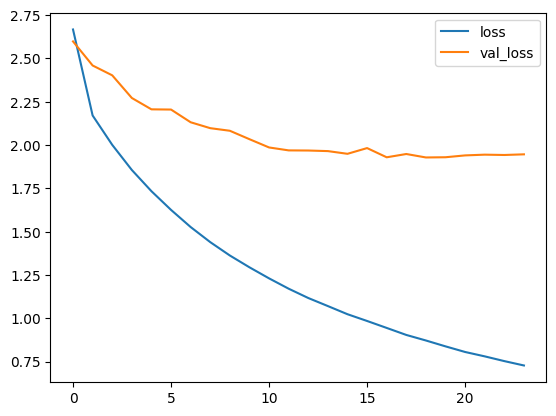

In [41]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

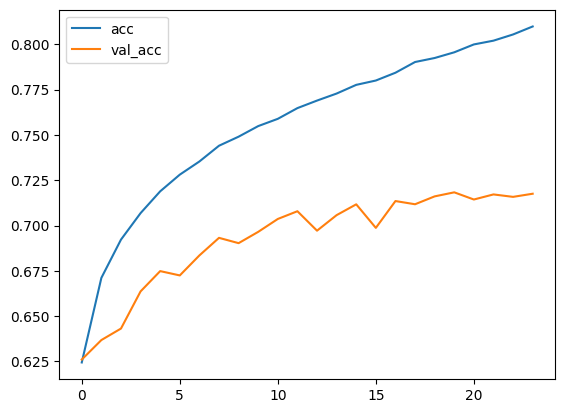

In [42]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [43]:
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

In [44]:
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [45]:
context = one_step_attention(encoder_outputs_as_input, initial_s)

decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

In [46]:
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)

In [47]:
decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s,
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)

In [48]:
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [49]:
def decode_sequence(input_seq):
  enc_out = encoder_model.predict(input_seq, verbose=0)

  target_seq = np.zeros((1,1))

  eos = word2idx_outputs['<eos>']

  s = np.zeros((1, LATENT_DIM_DECODER))
  c = np.zeros((1, LATENT_DIM_DECODER))

  output_sentence = []
  for _ in range(max_len_target):
    o, s, c = decoder_model.predict([target_seq, enc_out, s, c], verbose = 0)

    idx = np.argmax(o.flatten())

    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    target_seq[0, 0] = idx

  return ' '.join(output_sentence)



In [50]:
def translate():
  phrase = input("What word would you like to translate from English to Spanish? ")
  phrase_sequences = tokenizer_inputs.texts_to_sequences([phrase])
  pharse_encoded = pad_sequences(phrase_sequences, maxlen=max_len_input)
  return phrase, pharse_encoded

In [51]:
while True:
  phrase, pharse_encoded = translate()
  translation = decode_sequence(pharse_encoded)
  print('-')
  print('Input:', phrase)
  print('Translation:', translation)

  ans = input('Continue? [y/n] ')
  if ans and ans.lower().startswith('n'):
    break

What word would you like to translate from English to Spanish? dog
-
Input: dog
Translation: hola.
Continue? [y/n] y
What word would you like to translate from English to Spanish? girl
-
Input: girl
Translation: ¿quién? la
Continue? [y/n] y
What word would you like to translate from English to Spanish? hi
-
Input: hi
Translation: hola.
Continue? [y/n] y
What word would you like to translate from English to Spanish? man
-
Input: man
Translation: hola.
Continue? [y/n] n


In [52]:
encoder_model.save('encoder_model.keras')
decoder_model.save('decoder_model.keras')

In [53]:
with open('tokenizer.json', 'w') as file:
    json.dump(tokenizer_inputs.to_json(), file)

In [54]:
with open('idx2word_trans.pkl', 'wb') as f:
    pickle.dump(idx2word_trans, f)

In [55]:

with open('word2idx_outputs.pkl', 'wb') as f:
    pickle.dump(word2idx_outputs, f)